![](imgs/logo.png)

# Przetwarzanie Big Data z użyciem Apache Spark

Autor notebooka: Jakub Nowacki.


## Podstawy Spark SQL - People

In [1]:
import pyspark
import pyspark.sql.functions as func
sc = pyspark.SparkContext(appName='people')
sqlContext = pyspark.sql.SQLContext(sc)

In [2]:
people = sqlContext.read.json('data/people.json')

In [3]:
people.printSchema()

root
 |-- age: long (nullable = true)
 |-- children: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- name: string (nullable = true)
 |-- surname: string (nullable = true)



In [4]:
people.show()

+---+--------+------+-----+-------+
|age|children|gender| name|surname|
+---+--------+------+-----+-------+
| 25|       2|  male| John|    Doe|
| 35|       0|  male| Mike|    Foo|
| 65|       1|female|  Liz|    Bar|
| 34|       3|female|Emily|    Doe|
+---+--------+------+-----+-------+



## Używająć SQL

Do zapytań na DataFrames możemy użyc standardowego SQLa, dla którego będą one traktowane jak tabele w bazie danych. Pamiętaj, że Spark wspiera składnię ANSI/ISO SQL, więc konstrukcje typowe dla poszczególnych baz danych mogę nie być dostępne.

In [5]:
# Musisz najpierw zarejestrować tabelę zanim ją użyjesz w zapytaniu.
# Pamiętaj, że alias może mieć dowolną nazwę; nie jest on zależny od nazwy zmiennej.
people.registerTempTable('people')

In [7]:
# Teraz możemy wykonywać zapytania
r = sqlContext.sql('SELECT * FROM people where age < 36')
# Wynikiem jest nowy DataFrame
print(type(r))
# Metoda show() drukuje przykład danych
r.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+---+--------+------+-----+-------+
|age|children|gender| name|surname|
+---+--------+------+-----+-------+
| 25|       2|  male| John|    Doe|
| 35|       0|  male| Mike|    Foo|
| 34|       3|female|Emily|    Doe|
+---+--------+------+-----+-------+



In [8]:
sqlContext.sql('SELECT name, age FROM people').show()

+-----+---+
| name|age|
+-----+---+
| John| 25|
| Mike| 35|
|  Liz| 65|
|Emily| 34|
+-----+---+



In [9]:
sqlContext.sql('SELECT * FROM people WHERE age > 30').show()

+---+--------+------+-----+-------+
|age|children|gender| name|surname|
+---+--------+------+-----+-------+
| 35|       0|  male| Mike|    Foo|
| 65|       1|female|  Liz|    Bar|
| 34|       3|female|Emily|    Doe|
+---+--------+------+-----+-------+



In [10]:
# Możesz użyć docstring do dłuższych zapytań
query = """
    SELECT 
        gender,
        count(*) AS count, 
        avg(age) AS avg_age, 
        avg(children) AS avg_children 
    FROM people 
    GROUP BY gender
"""
sqlContext.sql(query).show()

+------+-----+-------+------------+
|gender|count|avg_age|avg_children|
+------+-----+-------+------------+
|female|    2|   49.5|         2.0|
|  male|    2|   30.0|         1.0|
+------+-----+-------+------------+



In [11]:
# Czasami trzeba uważać, np. poniższe nie zadziała
#sqlContext.sql("SELECT name, surname, max(age) as maxAge FROM people WHERE gender = 'male'").show()
# Ale to zadziała poprawnie
sqlContext.sql("SELECT first(name) AS name, first(surname) AS surname, max(age) as maxAge FROM people WHERE gender = 'male'").show()

+----+-------+------+
|name|surname|maxAge|
+----+-------+------+
|John|    Doe|    35|
+----+-------+------+



## Używanie metod DataFrame

Alternatywnie do zapytań SQL, Spark DataFrame posiadają metody podobne do SQL do budowania zapytań. Zaletą w stosunku do SQL jest m.in. to, że większość błędów w zapytaniach wykrywana jest w czasie kompilacji. 

In [15]:
people.select('name', 'gender').show()

+-----+------+
| name|gender|
+-----+------+
| John|  male|
| Mike|  male|
|  Liz|female|
|Emily|female|
+-----+------+



In [17]:
people.where(people.age > 30).where('children <> 0').show()

+---+--------+------+-----+-------+
|age|children|gender| name|surname|
+---+--------+------+-----+-------+
| 65|       1|female|  Liz|    Bar|
| 34|       3|female|Emily|    Doe|
+---+--------+------+-----+-------+



In [18]:
people.groupBy('gender') \
    .agg(
        func.avg('age').alias('avg_age'), 
        func.max('children').alias('max_children')
    ).show()
    


+------+-------+------------+
|gender|avg_age|max_children|
+------+-------+------------+
|female|   49.5|           3|
|  male|   30.0|           2|
+------+-------+------------+



In [20]:
people.groupBy('children').pivot('name').agg(func.avg('age')).show()

+--------+-----+----+----+----+
|children|Emily|John| Liz|Mike|
+--------+-----+----+----+----+
|       0| null|null|null|35.0|
|       1| null|null|65.0|null|
|       2| null|25.0|null|null|
|       3| 34.0|null|null|null|
+--------+-----+----+----+----+



In [21]:
people.where(people.gender == 'male') \
    .select(
        func.first('name').alias('name'), 
        func.first('surname').alias('surname'), 
        func.max('age').alias('maxAge')) \
    .show()

+----+-------+------+
|name|surname|maxAge|
+----+-------+------+
|John|    Doe|    35|
+----+-------+------+



/opt/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


,avg_age,max_children
gender,,
female,49.5,3
male,30.0,2


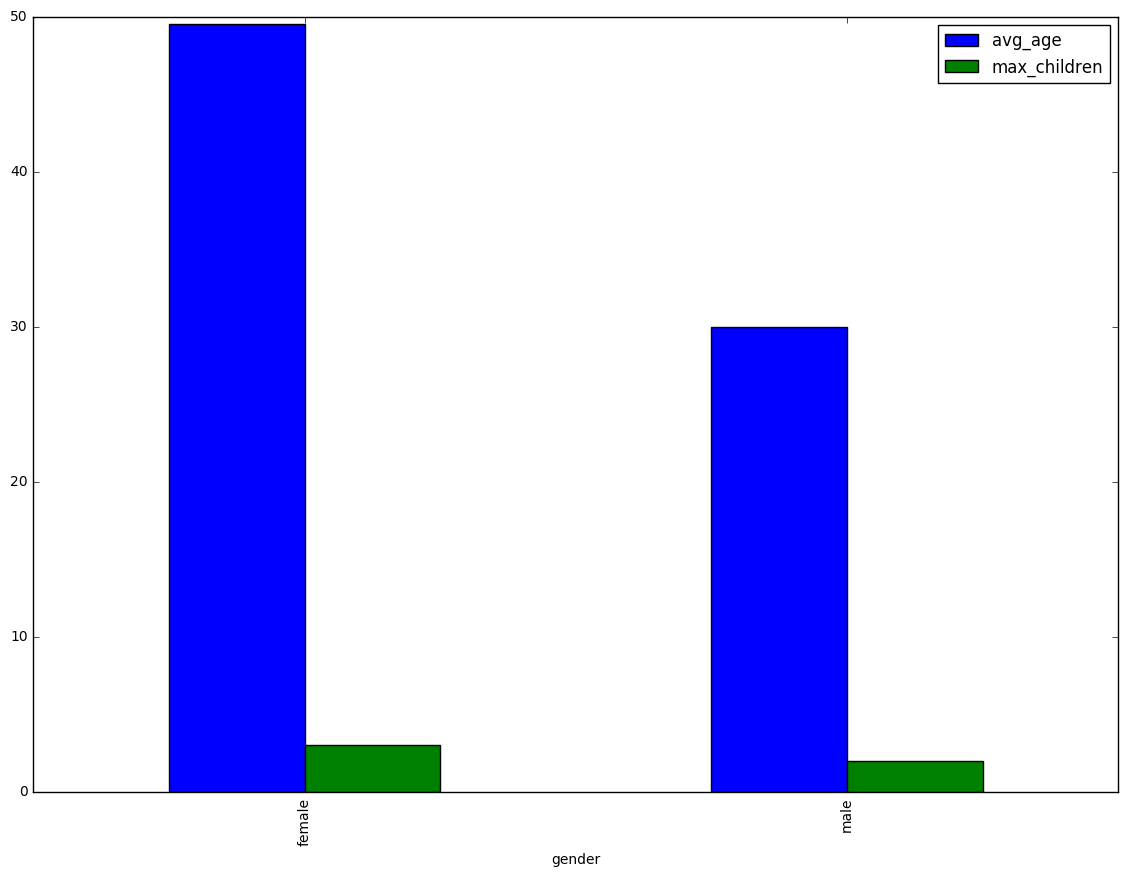

In [22]:
import matplotlib
%matplotlib inline

# Można otrzymywać data frame Pandas bezpośrednio z DataFrames; pamiętaj jednak o rozmiarze danych...
p = people.groupBy('gender').agg(func.avg('age').alias('avg_age'), func.max('children').alias('max_children')) \
        .toPandas().set_index('gender')
p.plot(kind='bar', figsize=(14,10))
p

## Zadania

Wypróbuj dostępne metody SQL i DataFrames. Sugestie:

* zbadaj dostępne funkcje
* spróbuj zapisać DataFrame
* spróbuj przekształcić DataFrame do RDD (podpowiedź: RDD zawiera obiekty Row)

In [27]:
rows = people.rdd.collect()
rows[2]['age']


1

In [29]:
rows[2].children

1

In [34]:
d =rows[2].asDict()
d

{'age': 65,
 'children': 1,
 'gender': u'female',
 'name': u'Liz',
 'surname': u'Bar'}

In [38]:
def fun2(age,children,gender,name,surname):
    print(age,children,gender,name,surname)

fun2(**d)
    

(65, 1, u'female', u'Liz', u'Bar')
